<a href="https://colab.research.google.com/github/alexandreib/QuantDesign/blob/main/2_SP500_Portfolio_Allocation_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Portfolio Optimization on S&P 500 Stocks Backtest**


## **Introduction**

In the previous [notebook](https://medium.com/@alexandre.durand/portfolio-optimisation-on-s-p-500-stocks-46f03732b030), we explored the theoretical foundations of portfolio optimization.
<br> <br>
Building on that analysis, this notebook delves into the practical implementation of backtesting three distinct portfolio optimization strategies using the S&P 500 index, specifically from **November 2021 to September 2024**.
<br><br>
 By backtesting these strategies over this defined period, we aim to evaluate their historical performance and compare their risk-adjusted returns, volatility, and overall effectiveness in adapting to changing market conditions. This analysis will offer insights into which optimization approach might best meet investor objectives in recent market environments.

<br><br>
Imports libraries :

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare data

Reusing the previously download stocks, from SP500 with 20 years of history.

Calculating the daily log return, and quaterly log return.

In [2]:
df = pd.read_csv('/content/drive/MyDrive/QuantDesign/Articles/Portfolio Optimization/sp500_20years.csv')

# Calculate daily log returns
df['Log_Return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

# # Calculate quarterly log returns Using the first advantage of log Rturns : Tie Additivity
# days before rebalancing :
days = 63
df['Quarterly_Log_Return'] = df.groupby('Ticker')['Log_Return'].rolling(window=days, min_periods=days).sum().reset_index(0, drop=True)

df.head(1)

,Date,Ticker,Adj Close,Log_Return,Quarterly_Log_Return
0,2004-11-22,MMM,37.598114,NaN,NaN


## Split DataFrame
<br>
To backtest our portfolio optimization, we will split on dataframe.<br><br>
We will use the date columns ot split  the data :<br>
- Train dataframe : not in that notebook. <br>
- Valid dataframe : used for Covariance Matrice Calculation.<br>
- Test dataframe : used for the Backtest.<br>
<br>

,Date,Ticker,Adj Close,Log_Return,Quarterly_Log_Return
4275,2021-11-15,MMM,133.632736,-0.001908,-0.077281
4338,2022-02-15,MMM,115.634094,-0.004249,-0.144664


train : 1771063 : 2004-11-22 -> 2018-11-14
valid : 379262 : 2018-11-15 -> 2021-11-12
test : 6036 : 2021-11-15 -> 2024-08-20


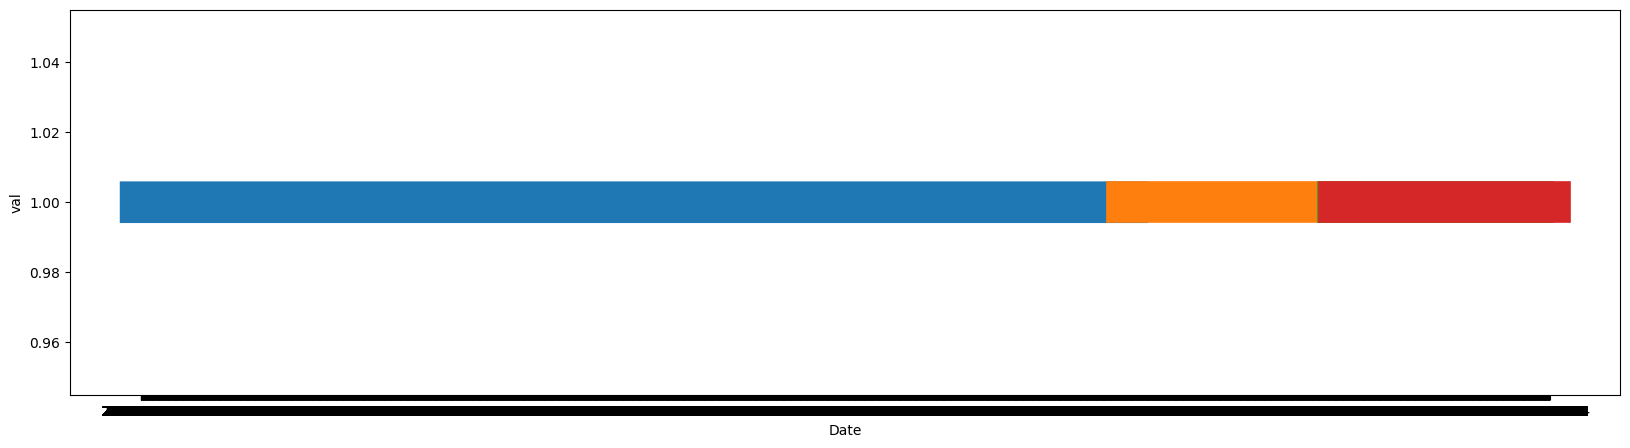

In [3]:
dates = list(df['Date'].unique())

dates_train = dates[:int(len(dates) * 0.7)]
dates_valid = dates[int(len(dates) * 0.7) : int(len(dates) * 0.85)]
dates_test = dates[int(len(dates) * 0.85):][0::days] ## Keep 1 rebalancing very 63 days

train = df[df['Date'].isin(dates_train)]
valid = df[df['Date'].isin(dates_valid)]
test = df[df['Date'].isin(dates_test)]
display(test.head(2))

print(f"train : {len(train)} : {train['Date'].min()} -> {train['Date'].max()}")
print(f"valid : {len(valid)} : {valid['Date'].min()} -> {valid['Date'].max()}")
print(f"test : {len(test)} : {test['Date'].min()} -> {test['Date'].max()}")


### visual verification
df_folds = pd.DataFrame(df['Date'])
df_folds.loc[df['Date'].isin(dates_train), 'plot'] = 'train'
df_folds.loc[df['Date'].isin(dates_valid), 'plot'] = 'valid'
df_folds.loc[df['Date'].isin(dates_test),  'plot'] = 'test'
df_folds['val'] = 1

plt.figure(figsize=(20,5))
plt.legend('',frameon=False)
ax = sns.lineplot(df_folds, x='Date', y = 'val', hue = 'plot',  linewidth = 30)
ax.get_legend().remove()
plt.show()
# del df_folds

Calculation of the covariance matrice on the valid dataframe :

In [4]:
def calculate_shrink_cov_matrix (df) :
    masked_arr = np.ma.array(df, mask=np.isnan(df))
    cov_numpy = np.ma.cov(masked_arr, rowvar=False, allow_masked=True, ddof=1).data
    n_samples, n_features = df.shape
    alpha = np.mean(cov_numpy**2)
    mu = np.trace(cov_numpy) / n_features
    mu_squared = mu**2
    num = alpha + mu_squared
    den = (n_samples + 1) * (alpha - mu_squared / n_features)
    shrinkage = 1.0 if den == 0 else min(num / den, 1.0)
    shrunk_cov = (1.0 - shrinkage) * cov_numpy
    shrunk_cov.flat[:: n_features + 1] += shrinkage * mu
    return shrunk_cov

# Creation of the log return Matrix
pivot_returns_valid = valid.pivot_table(values='Quarterly_Log_Return', columns='Ticker', index = 'Date')\
                         .fillna(0)

matrix_covariance = calculate_shrink_cov_matrix(pivot_returns_valid)
matrix_covariance = pd.DataFrame(matrix_covariance, columns = pivot_returns_valid.columns, index = pivot_returns_valid.columns)
matrix_covariance.head(1)

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Ticker,,,,,,,,,,,,,,,,,,,,,
A,0.012414,0.009793,0.007242,-0.000741,0.003243,0.008938,0.007759,0.006994,0.009076,0.008234,...,0.002136,0.013684,0.01623,0.000445,0.01152,0.008116,0.006407,0.00992,0.014424,0.0041


Calculating the returns on the test data :

In [5]:
pivot_returns_test = test.pivot_table(values='Quarterly_Log_Return', columns='Ticker', index = 'Date')\
                         .fillna(0)
pivot_returns_test.head(2)

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-15,-0.018399,0.000192,-0.011798,0.364614,0.033252,0.010919,0.115301,0.038190,0.111103,0.085397,...,0.063436,0.117882,0.064124,-0.077215,0.160534,-0.015744,-0.060002,-0.118484,0.048699,0.045965
2022-02-15,-0.147892,0.142715,0.224595,-0.140387,-0.039576,0.118307,-0.109413,-0.319087,-0.129014,0.148098,...,-0.028534,0.116203,-0.018425,0.034603,0.202958,-0.350089,-0.024812,-0.069129,-0.306202,-0.086897


Declaration of the functions to optimize the portfolio (see previous [notebook](https://medium.com/@alexandre.durand/portfolio-optimisation-on-s-p-500-stocks-46f03732b030) for more explanations).

In [6]:
def calculate_portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def calculate_portfolio_returns(weights, returns):
    return np.dot(weights, returns)

def variance_objective(weights, cov_matrix):
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return portfolio_variance

### Using Negative Markowitz Objective, as we will use scipy.optimize.minimize
def neg_markowitz_objective(weights, returns, cov_matrix, gamma = 0.2):
    portfolio_returns = np.squeeze(calculate_portfolio_returns(weights, returns))
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return gamma * portfolio_variance - portfolio_returns

### Using Negative Sharpe Ratio, as we will use scipy.optimize.minimize
def neg_sharpe_ratio_objective(weights, returns, cov_matrix, risk_free_rate = 0.03):
    portfolio_returns = np.squeeze(calculate_portfolio_returns(weights, returns))
    portfolio_variance = np.squeeze(calculate_portfolio_variance(weights, cov_matrix))
    return -((portfolio_returns - risk_free_rate)/np.sqrt(portfolio_variance))



Adding a generic Optimize weights functions , which can be called in loop :

In [7]:
### Generic Optimize weights functions
def optimize_weights(log_returns, covariance_matrix, fun=neg_markowitz_objective, x0 = None):
    number_of_tickers = len(log_returns)
    if x0 == None : x0 = np.array([1/number_of_tickers for _ in range(number_of_tickers)])
    if fun == calculate_portfolio_variance : args = (covariance_matrix)
    else : args = (log_returns, covariance_matrix)
    result = sp.optimize.minimize(fun = fun,
                                args = args,
                                x0 = x0,
                                method = 'SLSQP',
                                bounds = tuple((0, 0.3) for _ in range(number_of_tickers)),## we don't want to have more than 30% of the portfolio on 1 asset
                                constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
                                )
    return result.x

 <br>
 For the momnent, the prediction strategy is to use previous momentum/returns to decide on our weight allocation. <br>
 But we calculate the actual returns on the current quarter.<br>

<br>


## Backtest loop

In [8]:
results = {}
for idx in range(1, len(pivot_returns_test)):
    date = pivot_returns_test.iloc[idx].name
    results[date] = {}
    tickers = np.array(pivot_returns_test.iloc[idx].index)
    tickers_returns_future = pivot_returns_test.iloc[idx] # This Quarter returns which will be used to calculate the actual returns
    tickers_returns_pred = pivot_returns_test.iloc[idx - 1] # Previous Quarter returnswhich will be used to calculate the weights of our portfolio

    # Create Masks to keep only : Prediction > 0
    mask_preds_positives = tickers_returns_pred.values > 0
    # Create Masks to keep only : Tickers in the covariance Matrice ( calculated on Valid Data)
    mask_tickers_in_covariance_matrice = [True if col in matrix_covariance.columns else False for col in tickers]
    mask = mask_preds_positives & mask_tickers_in_covariance_matrice

    # Filtered Tickers, predictions, and real returns
    tickers = tickers[mask]
    tickers_returns_future = tickers_returns_future[mask]
    tickers_returns_pred = tickers_returns_pred[mask]
    matrix_covariance_filtered = matrix_covariance.loc[tickers, tickers]

    # # Creating random weighte allocation portfolio
    weights_random = np.random.rand(len(tickers))
    weights_random = weights_random / weights_random.sum()
    results[date][f'returns_weights_random'] = (weights_random * tickers_returns_future).sum()

    # Creating default weights for 3 types of portfolio potimized
    weights_sharpe = optimize_weights(tickers_returns_pred, matrix_covariance_filtered, fun = neg_sharpe_ratio_objective)
    results[date][f'returns_sharpe'] = (weights_sharpe * tickers_returns_future).sum()

    weights_min_variance= optimize_weights(tickers_returns_pred, matrix_covariance_filtered, fun = calculate_portfolio_variance)
    results[date][f'returns_min_variance'] =  (weights_min_variance * tickers_returns_future).sum()

    weights_mean_min_variance = optimize_weights(tickers_returns_pred, matrix_covariance_filtered, fun = neg_markowitz_objective)
    results[date][f'returns_mean_min_variance'] =  (weights_mean_min_variance * tickers_returns_future).sum()

# Results Analysis.

Transformn the results in a dataframe.<br>
We will also save the results dataframe to run other backtest, and try to improve our returns.

In [9]:
results = pd.DataFrame(results).T
display(results.head())
results.to_csv('/content/drive/MyDrive/QuantDesign/Articles/Portfolio Optimization/results.csv', index = False)

,returns_weights_random,returns_sharpe,returns_min_variance,returns_mean_min_variance
2022-02-15,-0.039957,-0.024808,-0.018082,0.038056
2022-05-17,-0.015792,0.141071,0.067760,-0.056570
2022-08-17,0.002829,0.025965,0.017349,-0.010126
2022-11-15,-0.048327,-0.047938,-0.004685,0.018745
2023-02-16,0.030218,-0.004707,-0.003316,0.016050


We will plot the  results achieved with the diffrent portfolio.

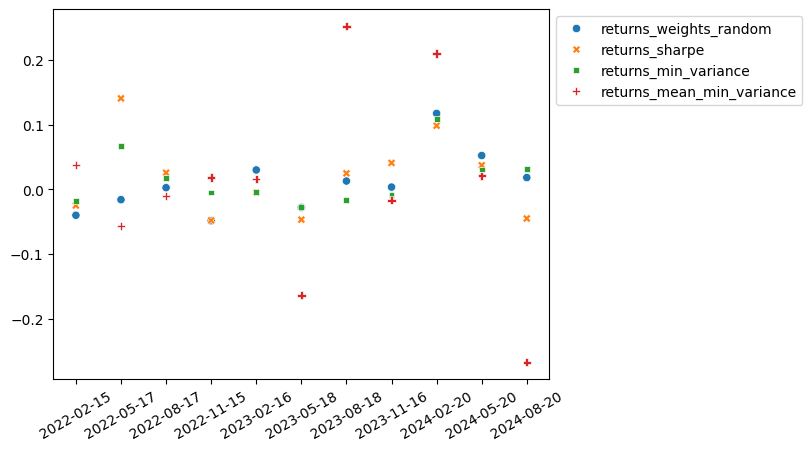

In [10]:
l_returns_columns = [x for x in results.columns if 'returns_' in x[:9]]

fig = plt.figure()
ax = sns.scatterplot(results[l_returns_columns], sizes = 3)
plt.xticks(rotation = 30)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

Let's plot the cumulatives returns of the diffrent strategies.

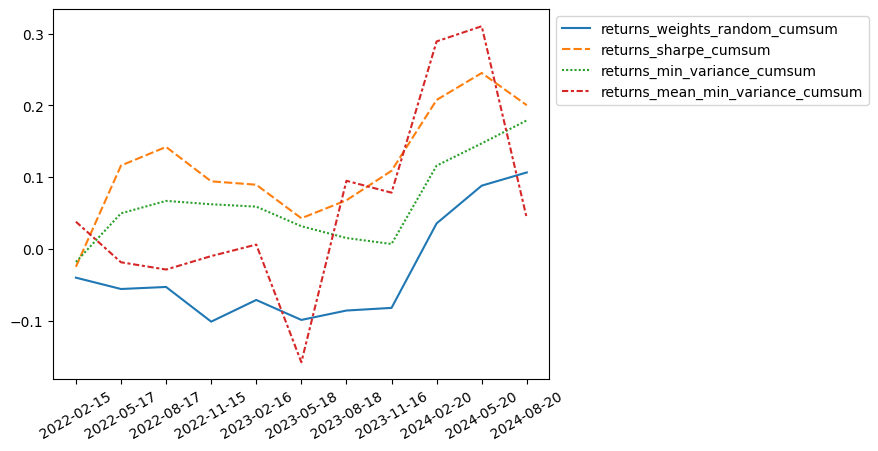

In [11]:
l_returns_columns_cumsum = [x + '_cumsum' for x in l_returns_columns]
results[l_returns_columns_cumsum] = results[l_returns_columns].cumsum()

fig = plt.figure() #figsize = (20, 15))
ax = sns.lineplot(results[l_returns_columns_cumsum], sizes = 3)
plt.xticks(rotation = 30)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [12]:
results[l_returns_columns].sum()

,0
returns_weights_random,0.106697
returns_sharpe,0.200338
returns_min_variance,0.179256
returns_mean_min_variance,0.042861


We can see that the maximum returns is achieved by the **Maximum Sharpe Ratio Portfolio**.

Let's calculate the actual achieved Sharpe ratio by the different portfolio :

In [16]:
results[l_returns_columns].mean() / results[l_returns_columns].std()

,0
returns_weights_random,0.206807
returns_sharpe,0.297246
returns_min_variance,0.391440
returns_mean_min_variance,0.026712


## **Conclusion**

In conclusion, the backtest conducted from **November 2021 to September 2024** highlights the relative performance of the three portfolio optimization strategies: the Minimum Variance Portfolio, the Maximum Sharpe Ratio Portfolio, and the quarterly rebalanced portfolio.<br>
<br>
The **Maximum Sharpe Ratio Portfolio** emerged as the most effective in terms of total return. <br>
While the **Minimum Variance Portfolio** excelled at minimizing risk, its returns were comparatively lower, making it less optimal in this period of market growth. <br>
<br>
Importantly, all 3 optimized portfolio outperformed the random portfolio weight allocation, demonstrating that even basic strategies allocation provide advantages overr randomasset allocaiton.
<br><br>
Looking ahead, the next step in this analysis will be to develop a model to predict future returns based on historical data and other market factors.
<br><br>
By forecasting expected returns, we can refine our portfolio optimization process and run the backtest again, incorporating these predictions into the strategy. <br>
This approach will allow us to test whether forward-looking optimization can improve portfolio performance and risk-adjusted returns.
<br><br>
The next notebook will focus on building and implementing this predictive model, providing further insights into how prediction-based strategies may enhance portfolio management.



